In [49]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams

import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

In [50]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

try:
    conn = psycopg2.connect(
        dbname=os.getenv('dbname'),
        user=os.getenv('user'),
        password=os.getenv('password'),
        host=os.getenv('host'),
        port=os.getenv('port')
    )
    print("Connection to PostgreSQL successful\n")

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

# ดึงข้อมูลจาก VIEW
query = "SELECT * FROM combined_indicators;"
df_all = pd.read_sql(query, conn)

# ลบ whitespace จาก ind_code
df_all['ind_code'] = df_all['ind_code'].str.strip()

# ตรวจสอบ ind_code ที่มีอยู่
print("Available indicators:")
print(sorted(df_all['ind_code'].unique()))
print()

# Pivot
df = df_all.pivot_table(
    index='date_month',
    columns='ind_code',
    values='value'
).reset_index()

print(f"Data loaded: {df.shape}")
print(f"Columns: {sorted(df.columns.tolist())}\n")

# เตรียมข้อมูล
df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month'])
df = df.asfreq('MS')  # ตั้งความถี่เป็น Monthly Start

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df

Connection to PostgreSQL successful



C:\Users\bankw\AppData\Local\Temp\ipykernel_28160\2765034889.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all = pd.read_sql(query, conn)


Available indicators:
['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']

Data loaded: (222, 11)
Columns: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP', 'date_month']

Data preparation completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2007-01-01 to 2025-06-01
Freq: MS
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EXR     222 non-null    float64
 1   OILP    222 non-null    float64
 2   PMI     222 non-null    float64
 3   TDC     222 non-null    float64
 4   TRI     222 non-null    float64
 5   TRP     222 non-null    float64
 6   TRPD    222 non-null    float64
 7   TRS     222 non-null    float64
 8   TRX     222 non-null    float64
 9   WRP     222 non-null    float64
dtypes: float64(10)
memory usage: 19.1 KB

Train data shape: (204, 10)
Test data shape: (18, 10)


C:\Users\bankw\AppData\Local\Temp\ipykernel_28160\2765034889.py:43: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


ind_code,EXR,OILP,PMI,TDC,TRI,TRP,TRPD,TRS,TRX,WRP
date_month,,,,,,,,,,
2007-01-01,36.1800,2103.5052,54.8,30652000.0,55000.0,65.12,328940000.0,2.806710e+08,267567000.0,75.1683
2007-02-01,35.7500,2208.9925,55.1,26790000.0,44000.0,72.91,267868000.0,2.490050e+08,237979000.0,81.4653
2007-03-01,35.0600,2309.4022,53.1,31717000.0,119000.0,69.62,246813000.0,2.173390e+08,230410000.0,78.6261
2007-04-01,34.8700,2291.3077,56.1,27788000.0,184000.0,72.84,165458000.0,1.785750e+08,180185000.0,80.9071
2007-05-01,34.6200,2216.0262,58.6,32905000.0,91000.0,71.47,172153000.0,2.092150e+08,178103000.0,82.0040
...,...,...,...,...,...,...,...,...,...,...
2025-02-01,33.9385,2367.5498,50.2,109368000.0,63000.0,67.91,578922000.0,1.050152e+09,369222000.0,82.4825
2025-03-01,33.9768,2428.6617,50.5,95398000.0,111000.0,66.56,413728000.0,9.991970e+08,369396000.0,81.3680
2025-04-01,33.9148,1974.1805,49.0,69306000.0,73000.0,59.69,267722000.0,8.799700e+08,317716000.0,73.9204


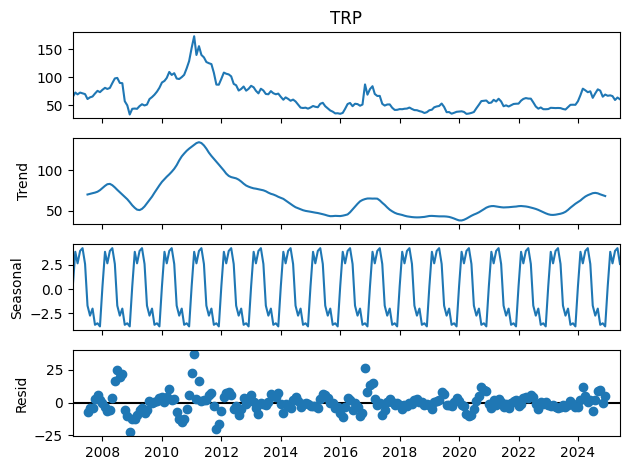

In [51]:
result = seasonal_decompose(df['TRP'], model='additive', period=12)
result.plot()
plt.show()

Available columns: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected external factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Mean TRP (train): 64.5769
X_train: (204, 9)  X_test: (18, 9)


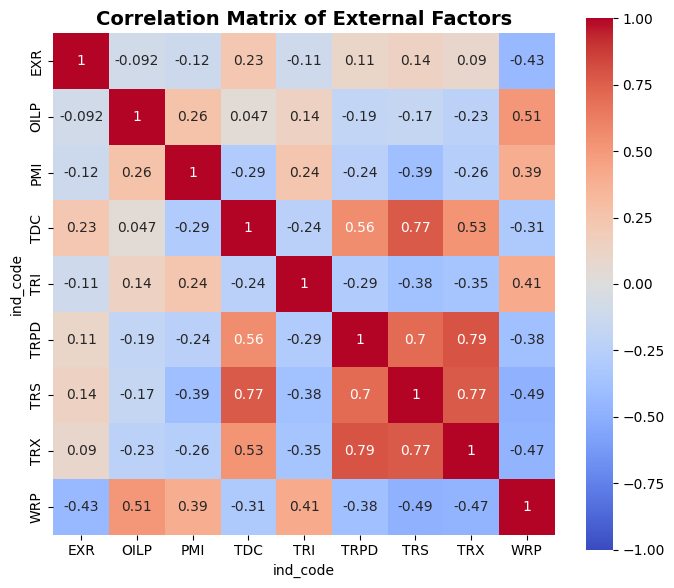

In [52]:
external_factors = ['EXR', 'OILP', 'PMI','TDC', 'TRI', 'TRPD','TRS', 'TRX', 'WRP']

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

#เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train = train_exog.copy()
X_test  = test_exog.copy()
y_train = train_data['TRP']
y_test  = test_data['TRP']

mean_trp = y_train.mean()
print(f"Mean TRP (train): {mean_trp:.4f}")
print("X_train:", X_train.shape, " X_test:", X_test.shape)

#Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [53]:
before_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
before_model.fit(X_train, y_train)
pred_before = before_model.predict(X_test)

rmse_before = np.sqrt(mean_squared_error(y_test, pred_before))
mape_before = mean_absolute_percentage_error(y_test, pred_before)*100

print("=== BEFORE MODEL ===")
print("RMSE:", rmse_before)
print("MAPE:", mape_before)


=== BEFORE MODEL ===
RMSE: 4.302440228524894
MAPE: 4.837908357756341


In [54]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 700),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10),
        "random_state": 42
    }

    model = XGBRegressor(**params, objective='reg:squarederror')
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    return mean_squared_error(y_test, pred, squared=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60)

best_params = study.best_params
print("\nBest Params:", best_params)


[I 2025-11-25 03:01:59,620] A new study created in memory with name: no-name-1c86c78d-84e8-4b60-becf-0b381e13ba09
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-11-25 03:01:59,947] Trial 0 finished with value: 6.887022932107566 and parameters: {'n_estimators': 583, 'learning_rate': 0.008683681024778168, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.11781493685497293, 'subsample': 0.8763480209014411, 'colsample_bytree': 0.7400024938305955, 'reg_alpha': 0.8821584688010785, 'reg_lambda': 4.776287826756807}. Best is trial 0 with value: 6.887022932107566.
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in


Best Params: {'n_estimators': 643, 'learning_rate': 0.008095528936719089, 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0.07868274584421713, 'subsample': 0.9812815023250094, 'colsample_bytree': 0.9140779352499628, 'reg_alpha': 0.3159334320279917, 'reg_lambda': 1.6697949162494474}


In [55]:
after_model = XGBRegressor(
    **best_params, objective='reg:squarederror'
)

after_model.fit(X_train, y_train)
pred_after = after_model.predict(X_test)

rmse_after = np.sqrt(mean_squared_error(y_test, pred_after))
mape_after = mean_absolute_percentage_error(y_test, pred_after)*100

print("=== AFTER MODEL (Optuna) ===")
print("RMSE:", rmse_after)
print("MAPE:", mape_after)


=== AFTER MODEL (Optuna) ===
RMSE: 2.555587704598877
MAPE: 3.2535119391339413


In [56]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    nrmse = rmse / mean_trp
    mape_norm = mape / 100
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return score

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after, mape_after, mean_trp)

print("\n=== SCORE ===")
print("Before:", score_before)
print("After :", score_after)


=== SCORE ===
Before: 94.24979059623753
After : 96.39452626995087


In [57]:
comparison_df = pd.DataFrame({
    "Model": ["Before", "After (Optuna)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [mape_before, mape_after],
    "Score": [score_before, score_after]
})

print("\n=== COMPARISON TABLE ===")
print(comparison_df.to_string(index=False))


=== COMPARISON TABLE ===
         Model     RMSE  MAPE (%)     Score
        Before 4.302440  4.837908 94.249791
After (Optuna) 2.555588  3.253512 96.394526


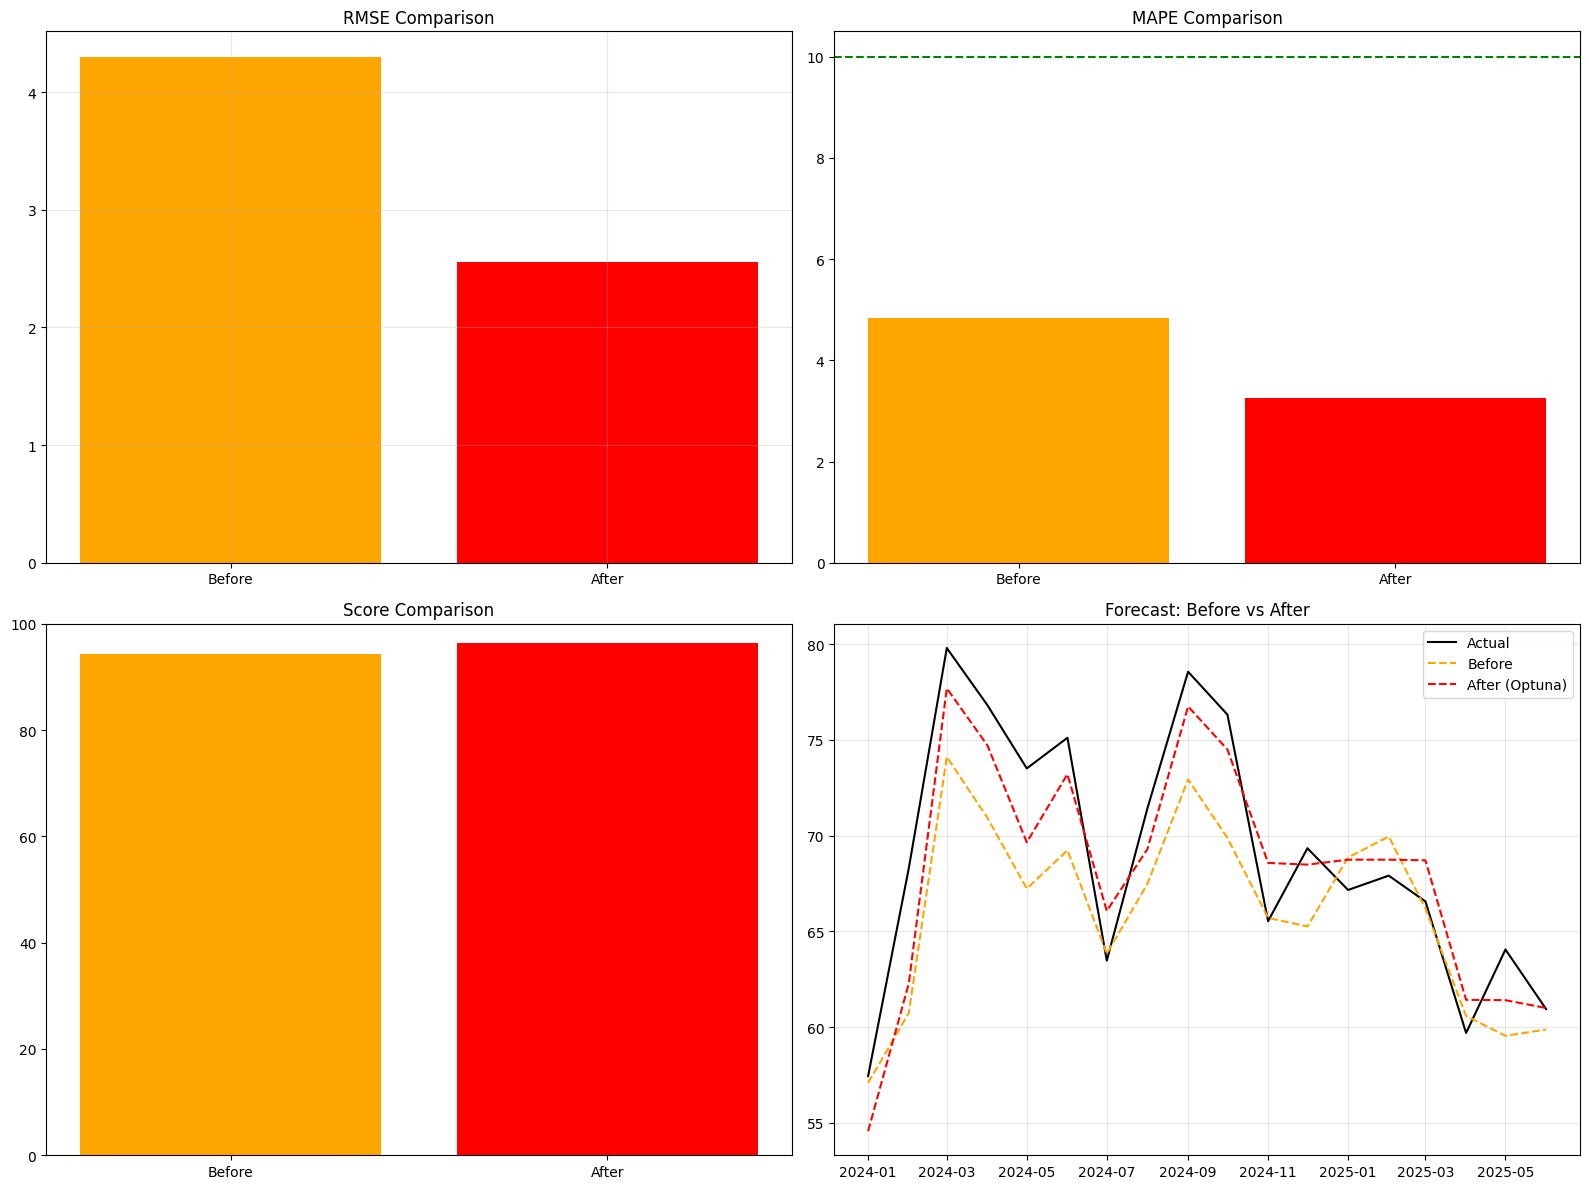

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE
axes[0, 0].bar(["Before", "After"], [rmse_before, rmse_after], color=['orange','red'])
axes[0, 0].set_title("RMSE Comparison")
axes[0, 0].grid(True, alpha=0.3)

# MAPE
axes[0, 1].bar(["Before", "After"], [mape_before, mape_after], color=['orange','red'])
axes[0, 1].set_title("MAPE Comparison")
axes[0, 1].axhline(10, color='green', linestyle='--')

# Score
axes[1, 0].bar(["Before", "After"], [score_before, score_after], color=['orange','red'])
axes[1, 0].set_ylim(0, 100)
axes[1, 0].set_title("Score Comparison")

# Forecast
axes[1, 1].plot(y_test.index, y_test.values, label="Actual", color='black')
axes[1, 1].plot(y_test.index, pred_before, label="Before", linestyle='--', color='orange')
axes[1, 1].plot(y_test.index, pred_after, label="After (Optuna)", linestyle='--', color='red')
axes[1, 1].set_title("Forecast: Before vs After")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


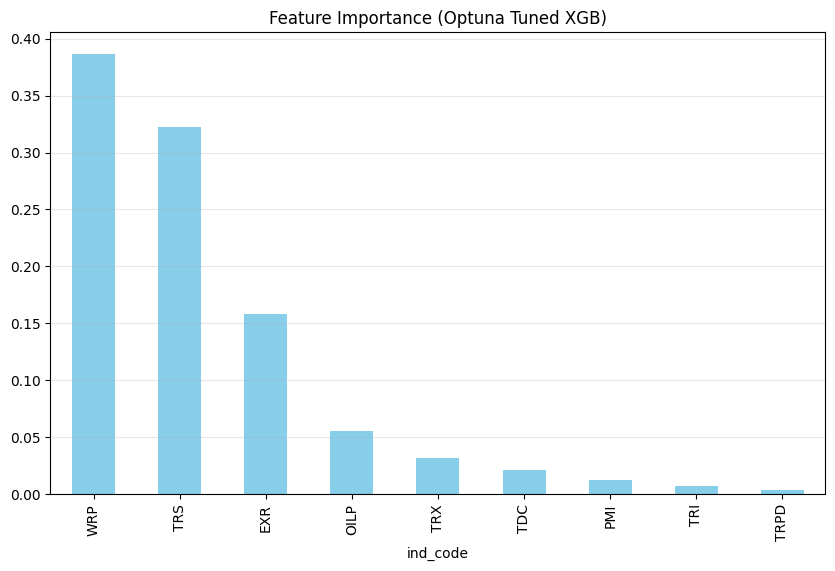

In [60]:
importances = pd.Series(after_model.feature_importances_, index=X_train.columns)\
                .sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance (Optuna Tuned XGB)")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [61]:
data = {
    'Model': ['Before (Fixed XGB)', 'After (Optuna Tuned)'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100], 
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

#Format MAPE and ACCURACY as percentages
df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

#Compare table display
df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison\n")
print(df_display.to_string(index=True, col_space=12))


Performance Comparison

                             Model         RMSE     MAPE (%) ACCURACY (%)
0               Before (Fixed XGB)     4.302440        4.84%       94.25%
1             After (Optuna Tuned)     2.555588        3.25%       96.39%
